In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - \ done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def single_category_regressor(features, context, context2, unitsNumber = 64):
    features = concatenate([features, context])
    
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    features = concatenate([dense_1_dropout, context2])

    dense_2 = Dense(unitsNumber, activation = 'elu')(features)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='sigmoid')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)


dense_1 = Dense(512, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(512, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

single_category_layer = concatenate([
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
])

output_layer = add([output_layer, single_category_layer])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 8:09 - loss: 4.7090 - acc: 0.5591

 57664/102124 [===============>..............] - ETA: 4:27 - loss: 2.8790 - acc: 0.6962

102112/102124 [============================>.] - ETA: 0s - loss: 1.7784 - acc: 0.7993

102124/102124 [==============================] - 656s 6ms/step - loss: 1.7782 - acc: 0.7993 - val_loss: 0.1663 - val_acc: 0.9621
Epoch 2/32
  9824/102124 [=>............................] - ETA: 9:24 - loss: 0.1749 - acc: 0.9572

 86784/102124 [========================>.....] - ETA: 1:30 - loss: 0.1456 - acc: 0.9611

102124/102124 [==============================] - 643s 6ms/step - loss: 0.1384 - acc: 0.9627 - val_loss: 0.1028 - val_acc: 0.9720
roc-auc: 0.9474 - roc-auc_val: 0.9456                                                                                                    
Epoch 3/32
  5088/102124 [>.............................] - ETA: 9:34 - loss: 0.0939 - acc: 0.9725

 48992/102124 [=============>................] - ETA: 5:08 - loss: 0.0863 - acc: 0.9734

 93632/102124 [==========================>...] - ETA: 49s - loss: 0.0828 - acc: 0.9737

102124/102124 [==============================] - 635s 6ms/step - loss: 0.0820 - acc: 0.9738 - val_loss: 0.0702 - val_acc: 0.9760
Epoch 4/32
 10592/102124 [==>...........................] - ETA: 9:08 - loss: 0.0746 - acc: 0.9747

 48256/102124 [=============>................] - ETA: 5:24 - loss: 0.0686 - acc: 0.9762

102112/102124 [============================>.] - ETA: 0s - loss: 0.0669 - acc: 0.9767

102124/102124 [==============================] - 640s 6ms/step - loss: 0.0669 - acc: 0.9767 - val_loss: 0.0569 - val_acc: 0.9794
roc-auc: 0.9765 - roc-auc_val: 0.9722                                                                                                    
Epoch 5/32
  8576/102124 [=>............................] - ETA: 8:58 - loss: 0.0641 - acc: 0.9775

 56928/102124 [===============>..............] - ETA: 4:18 - loss: 0.0612 - acc: 0.9783

 94368/102124 [==========================>...] - ETA: 44s - loss: 0.0602 - acc: 0.9785

102124/102124 [==============================] - 627s 6ms/step - loss: 0.0601 - acc: 0.9785 - val_loss: 0.0538 - val_acc: 0.9804
Epoch 6/32
 10944/102124 [==>...........................] - ETA: 9:12 - loss: 0.0574 - acc: 0.9791

 52128/102124 [==============>...............] - ETA: 5:05 - loss: 0.0561 - acc: 0.9793

 87456/102124 [========================>.....] - ETA: 1:33 - loss: 0.0553 - acc: 0.9794

102124/102124 [==============================] - 686s 7ms/step - loss: 0.0550 - acc: 0.9796 - val_loss: 0.0505 - val_acc: 0.9819
roc-auc: 0.9857 - roc-auc_val: 0.984                                                                                                    
Epoch 7/32
  5184/102124 [>.............................] - ETA: 10:10 - loss: 0.0510 - acc: 0.9805

 72672/102124 [====================>.........] - ETA: 2:55 - loss: 0.0526 - acc: 0.9802

102124/102124 [==============================] - 643s 6ms/step - loss: 0.0522 - acc: 0.9804 - val_loss: 0.0489 - val_acc: 0.9816
Epoch 8/32
  2720/102124 [..............................] - ETA: 9:38 - loss: 0.0581 - acc: 0.9784

 40352/102124 [==========>...................] - ETA: 6:08 - loss: 0.0495 - acc: 0.9814

 81344/102124 [======================>.......] - ETA: 2:04 - loss: 0.0499 - acc: 0.9812

102124/102124 [==============================] - 653s 6ms/step - loss: 0.0499 - acc: 0.9812 - val_loss: 0.0456 - val_acc: 0.9834
roc-auc: 0.9868 - roc-auc_val: 0.9843                                                                                                    
Epoch 9/32
  3680/102124 [>.............................] - ETA: 10:32 - loss: 0.0482 - acc: 0.9825

 40224/102124 [==========>...................] - ETA: 6:10 - loss: 0.0474 - acc: 0.9820

 76736/102124 [=====================>........] - ETA: 2:32 - loss: 0.0475 - acc: 0.9820

102124/102124 [==============================] - 655s 6ms/step - loss: 0.0481 - acc: 0.9818 - val_loss: 0.0497 - val_acc: 0.9814
Epoch 10/32
  4096/102124 [>.............................] - ETA: 10:06 - loss: 0.0455 - acc: 0.9827

 42656/102124 [===========>..................] - ETA: 6:15 - loss: 0.0455 - acc: 0.9823

 80096/102124 [======================>.......] - ETA: 2:19 - loss: 0.0462 - acc: 0.9823

102124/102124 [==============================] - 683s 7ms/step - loss: 0.0468 - acc: 0.9820 - val_loss: 0.0427 - val_acc: 0.9838
roc-auc: 0.9903 - roc-auc_val: 0.9869                                                                                                    
Epoch 11/32
  3360/102124 [..............................] - ETA: 9:26 - loss: 0.0446 - acc: 0.9823

 54976/102124 [===============>..............] - ETA: 4:32 - loss: 0.0454 - acc: 0.9823

 90624/102124 [=========================>....] - ETA: 1:07 - loss: 0.0455 - acc: 0.9823

102124/102124 [==============================] - 647s 6ms/step - loss: 0.0453 - acc: 0.9824 - val_loss: 0.0412 - val_acc: 0.9840
Epoch 12/32
  8800/102124 [=>............................] - ETA: 9:35 - loss: 0.0453 - acc: 0.9824

 44256/102124 [============>.................] - ETA: 6:03 - loss: 0.0449 - acc: 0.9824

 79872/102124 [======================>.......] - ETA: 2:17 - loss: 0.0447 - acc: 0.9827

102124/102124 [==============================] - 664s 7ms/step - loss: 0.0443 - acc: 0.9829 - val_loss: 0.0449 - val_acc: 0.9834
roc-auc: 0.9839 - roc-auc_val: 0.9794                                                                                                    
Epoch 13/32
  3360/102124 [..............................] - ETA: 9:41 - loss: 0.0461 - acc: 0.9823

 39744/102124 [==========>...................] - ETA: 6:07 - loss: 0.0433 - acc: 0.9830

 77888/102124 [=====================>........] - ETA: 2:23 - loss: 0.0436 - acc: 0.9829

102124/102124 [==============================] - 653s 6ms/step - loss: 0.0437 - acc: 0.9829 - val_loss: 0.0421 - val_acc: 0.9839

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00014358729822561145.
Epoch 14/32
  2880/102124 [..............................] - ETA: 10:21 - loss: 0.0398 - acc: 0.9851

 47744/102124 [=============>................] - ETA: 5:33 - loss: 0.0421 - acc: 0.9836

 85504/102124 [========================>.....] - ETA: 1:42 - loss: 0.0424 - acc: 0.9834

102124/102124 [==============================] - 666s 7ms/step - loss: 0.0429 - acc: 0.9832 - val_loss: 0.0547 - val_acc: 0.9809
roc-auc: 0.9895 - roc-auc_val: 0.9848                                                                                                    
Epoch 15/32
  4416/102124 [>.............................] - ETA: 10:14 - loss: 0.0429 - acc: 0.9840

 39968/102124 [==========>...................] - ETA: 6:23 - loss: 0.0423 - acc: 0.9831

 74816/102124 [====================>.........] - ETA: 2:47 - loss: 0.0425 - acc: 0.9832

102124/102124 [==============================] - 675s 7ms/step - loss: 0.0422 - acc: 0.9833 - val_loss: 0.0425 - val_acc: 0.9840
Epoch 16/32
  2944/102124 [..............................] - ETA: 9:51 - loss: 0.0421 - acc: 0.9845

 44320/102124 [============>.................] - ETA: 5:46 - loss: 0.0410 - acc: 0.9838

 79776/102124 [======================>.......] - ETA: 2:15 - loss: 0.0410 - acc: 0.9839

102124/102124 [==============================] - 662s 6ms/step - loss: 0.0413 - acc: 0.9837 - val_loss: 0.0426 - val_acc: 0.9836
roc-auc: 0.9922 - roc-auc_val: 0.9856                                                                                                    
Epoch 17/32
  2944/102124 [..............................] - ETA: 10:19 - loss: 0.0364 - acc: 0.9859

 41664/102124 [===========>..................] - ETA: 5:56 - loss: 0.0393 - acc: 0.9846

 81152/102124 [======================>.......] - ETA: 2:03 - loss: 0.0400 - acc: 0.9842

102124/102124 [==============================] - 643s 6ms/step - loss: 0.0402 - acc: 0.9842 - val_loss: 0.0421 - val_acc: 0.9840
Epoch 18/32
  5600/102124 [>.............................] - ETA: 9:32 - loss: 0.0409 - acc: 0.9843

 45920/102124 [============>.................] - ETA: 5:34 - loss: 0.0404 - acc: 0.9840

 80800/102124 [======================>.......] - ETA: 2:09 - loss: 0.0398 - acc: 0.9842

102124/102124 [==============================] - 661s 6ms/step - loss: 0.0398 - acc: 0.9842 - val_loss: 0.0427 - val_acc: 0.9842
roc-auc: 0.992 - roc-auc_val: 0.9852                                                                                                    
Epoch 19/32
  3168/102124 [..............................] - ETA: 10:39 - loss: 0.0392 - acc: 0.9850

 39104/102124 [==========>...................] - ETA: 6:21 - loss: 0.0389 - acc: 0.9844

 83520/102124 [=======================>......] - ETA: 1:51 - loss: 0.0394 - acc: 0.9843

102124/102124 [==============================] - 647s 6ms/step - loss: 0.0395 - acc: 0.9844 - val_loss: 0.0413 - val_acc: 0.9840
Epoch 20/32
  6752/102124 [>.............................] - ETA: 9:26 - loss: 0.0366 - acc: 0.9847

 44704/102124 [============>.................] - ETA: 5:41 - loss: 0.0385 - acc: 0.9846

 80832/102124 [======================>.......] - ETA: 2:08 - loss: 0.0392 - acc: 0.9843

102124/102124 [==============================] - 662s 6ms/step - loss: 0.0392 - acc: 0.9842 - val_loss: 0.0426 - val_acc: 0.9832
roc-auc: 0.9926 - roc-auc_val: 0.9855                                                                                                    
Epoch 21/32
  3104/102124 [..............................] - ETA: 10:19 - loss: 0.0387 - acc: 0.9848

 45344/102124 [============>.................] - ETA: 5:41 - loss: 0.0388 - acc: 0.9843

 81888/102124 [=======================>......] - ETA: 2:03 - loss: 0.0385 - acc: 0.9846

102124/102124 [==============================] - 664s 7ms/step - loss: 0.0384 - acc: 0.9847 - val_loss: 0.0423 - val_acc: 0.9838


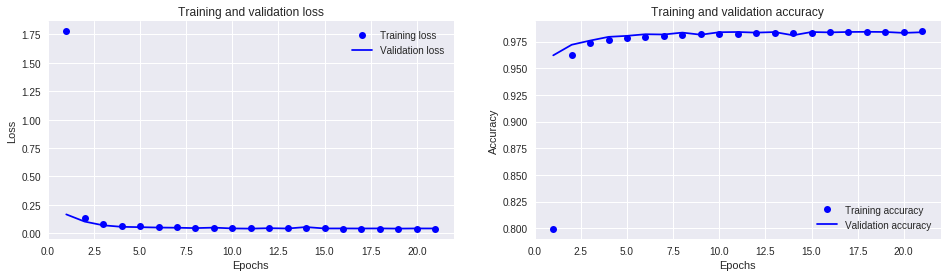

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 55s 2ms/step
([0.03963553109746844, 0.984307260969375], 0.9889347934130369)


In [13]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42816/102124 [===========>..................] - ETA: 5:31 - loss: 2.5007 - acc: 0.7663

102124/102124 [==============================] - 586s 6ms/step - loss: 1.1606 - acc: 0.8785 - val_loss: 0.1365 - val_acc: 0.9638
Epoch 2/32
  5376/102124 [>.............................] - ETA: 8:18 - loss: 0.1018 - acc: 0.9707

102080/102124 [============================>.] - ETA: 0s - loss: 0.0840 - acc: 0.9742

102124/102124 [==============================] - 569s 6ms/step - loss: 0.0839 - acc: 0.9742 - val_loss: 0.1269 - val_acc: 0.9644
roc-auc: 0.949 - roc-auc_val: 0.9517                                                                                                    
Epoch 3/32
 17472/102124 [====>.........................] - ETA: 7:18 - loss: 0.0727 - acc: 0.9767

102080/102124 [============================>.] - ETA: 0s - loss: 0.0685 - acc: 0.9771

102124/102124 [==============================] - 569s 6ms/step - loss: 0.0685 - acc: 0.9771 - val_loss: 0.0575 - val_acc: 0.9808
Epoch 4/32
 20352/102124 [====>.........................] - ETA: 7:03 - loss: 0.0628 - acc: 0.9783

102080/102124 [============================>.] - ETA: 0s - loss: 0.0621 - acc: 0.9782

102124/102124 [==============================] - 569s 6ms/step - loss: 0.0621 - acc: 0.9782 - val_loss: 0.0545 - val_acc: 0.9811
roc-auc: 0.9742 - roc-auc_val: 0.9732                                                                                                    
Epoch 5/32
 17408/102124 [====>.........................] - ETA: 7:18 - loss: 0.0599 - acc: 0.9790

102080/102124 [============================>.] - ETA: 0s - loss: 0.0580 - acc: 0.9791

102124/102124 [==============================] - 569s 6ms/step - loss: 0.0580 - acc: 0.9791 - val_loss: 0.0547 - val_acc: 0.9802
Epoch 6/32
 20352/102124 [====>.........................] - ETA: 7:05 - loss: 0.0534 - acc: 0.9810

102080/102124 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9802

102124/102124 [==============================] - 569s 6ms/step - loss: 0.0543 - acc: 0.9802 - val_loss: 0.0779 - val_acc: 0.9763

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00029730176902376115.
roc-auc: 0.98 - roc-auc_val: 0.979                                                                                                    
Epoch 7/32
 11904/102124 [==>...........................] - ETA: 7:49 - loss: 0.0535 - acc: 0.9804

102080/102124 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9808

102124/102124 [==============================] - 568s 6ms/step - loss: 0.0516 - acc: 0.9808 - val_loss: 0.0480 - val_acc: 0.9819
Epoch 8/32
 20352/102124 [====>.........................] - ETA: 6:57 - loss: 0.0489 - acc: 0.9816

102080/102124 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9813

102124/102124 [==============================] - 562s 5ms/step - loss: 0.0496 - acc: 0.9813 - val_loss: 0.0599 - val_acc: 0.9798
roc-auc: 0.9818 - roc-auc_val: 0.9791                                                                                                    
Epoch 9/32
 17408/102124 [====>.........................] - ETA: 7:17 - loss: 0.0487 - acc: 0.9813

102080/102124 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9817

102124/102124 [==============================] - 567s 6ms/step - loss: 0.0480 - acc: 0.9817 - val_loss: 0.0685 - val_acc: 0.9775
Epoch 10/32
 20288/102124 [====>.........................] - ETA: 7:01 - loss: 0.0470 - acc: 0.9818

102080/102124 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9820

102124/102124 [==============================] - 564s 6ms/step - loss: 0.0470 - acc: 0.9820 - val_loss: 0.0483 - val_acc: 0.9828
roc-auc: 0.989 - roc-auc_val: 0.9858                                                                                                    
Epoch 11/32
 17408/102124 [====>.........................] - ETA: 7:21 - loss: 0.0457 - acc: 0.9823

102080/102124 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9826

102124/102124 [==============================] - 568s 6ms/step - loss: 0.0451 - acc: 0.9827 - val_loss: 0.0471 - val_acc: 0.9823
Epoch 12/32
 20288/102124 [====>.........................] - ETA: 7:06 - loss: 0.0420 - acc: 0.9837

102080/102124 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9828

102124/102124 [==============================] - 568s 6ms/step - loss: 0.0445 - acc: 0.9828 - val_loss: 0.0650 - val_acc: 0.9786
roc-auc: 0.9839 - roc-auc_val: 0.9794                                                                                                    
Epoch 13/32
 17344/102124 [====>.........................] - ETA: 7:17 - loss: 0.0443 - acc: 0.9831

102080/102124 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9830

102124/102124 [==============================] - 568s 6ms/step - loss: 0.0436 - acc: 0.9830 - val_loss: 0.0550 - val_acc: 0.9789
Epoch 14/32
 20288/102124 [====>.........................] - ETA: 6:59 - loss: 0.0420 - acc: 0.9834

102080/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9834

102124/102124 [==============================] - 565s 6ms/step - loss: 0.0425 - acc: 0.9834 - val_loss: 0.0434 - val_acc: 0.9836
roc-auc: 0.9917 - roc-auc_val: 0.9871                                                                                                    
Epoch 15/32
 17344/102124 [====>.........................] - ETA: 7:16 - loss: 0.0408 - acc: 0.9841

102080/102124 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9837

102124/102124 [==============================] - 562s 6ms/step - loss: 0.0414 - acc: 0.9837 - val_loss: 0.0439 - val_acc: 0.9835
Epoch 16/32
 20288/102124 [====>.........................] - ETA: 7:12 - loss: 0.0405 - acc: 0.9842

102080/102124 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9839

102124/102124 [==============================] - 558s 5ms/step - loss: 0.0411 - acc: 0.9839 - val_loss: 0.0536 - val_acc: 0.9825
roc-auc: 0.9898 - roc-auc_val: 0.9841                                                                                                    
Epoch 17/32
 17344/102124 [====>.........................] - ETA: 7:05 - loss: 0.0420 - acc: 0.9831

102080/102124 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9842

102124/102124 [==============================] - 550s 5ms/step - loss: 0.0402 - acc: 0.9842 - val_loss: 0.0590 - val_acc: 0.9797

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.473228419665247e-05.
Epoch 18/32
 16064/102124 [===>..........................] - ETA: 7:10 - loss: 0.0393 - acc: 0.9842

102080/102124 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9841

102124/102124 [==============================] - 549s 5ms/step - loss: 0.0398 - acc: 0.9841 - val_loss: 0.0406 - val_acc: 0.9843
roc-auc: 0.9937 - roc-auc_val: 0.9884                                                                                                    
Epoch 19/32
 17344/102124 [====>.........................] - ETA: 7:06 - loss: 0.0395 - acc: 0.9846

102080/102124 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9847

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0394 - acc: 0.9847 - val_loss: 0.0428 - val_acc: 0.9841
Epoch 20/32
 20288/102124 [====>.........................] - ETA: 6:51 - loss: 0.0378 - acc: 0.9849

102080/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9845

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0385 - acc: 0.9845 - val_loss: 0.0449 - val_acc: 0.9826
roc-auc: 0.9938 - roc-auc_val: 0.9871                                                                                                    
Epoch 21/32
 17344/102124 [====>.........................] - ETA: 7:06 - loss: 0.0385 - acc: 0.9849

102080/102124 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9847

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0385 - acc: 0.9847 - val_loss: 0.0589 - val_acc: 0.9806
Epoch 22/32
 20288/102124 [====>.........................] - ETA: 6:52 - loss: 0.0352 - acc: 0.9863

102080/102124 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9848

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0379 - acc: 0.9848 - val_loss: 0.0434 - val_acc: 0.9840
roc-auc: 0.9933 - roc-auc_val: 0.9856                                                                                                    
Epoch 23/32
 17344/102124 [====>.........................] - ETA: 7:05 - loss: 0.0381 - acc: 0.9845

102080/102124 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9850

102124/102124 [==============================] - 550s 5ms/step - loss: 0.0373 - acc: 0.9850 - val_loss: 0.0708 - val_acc: 0.9810
Epoch 24/32
 20288/102124 [====>.........................] - ETA: 6:50 - loss: 0.0357 - acc: 0.9861

102080/102124 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9853

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0367 - acc: 0.9853 - val_loss: 0.0445 - val_acc: 0.9837
roc-auc: 0.9946 - roc-auc_val: 0.987                                                                                                    
Epoch 25/32
 17408/102124 [====>.........................] - ETA: 7:08 - loss: 0.0365 - acc: 0.9856

102080/102124 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9853

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0365 - acc: 0.9853 - val_loss: 0.0455 - val_acc: 0.9840
Epoch 26/32
 20288/102124 [====>.........................] - ETA: 6:54 - loss: 0.0360 - acc: 0.9854

102080/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9853

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0363 - acc: 0.9853 - val_loss: 0.0500 - val_acc: 0.9829
roc-auc: 0.994 - roc-auc_val: 0.9847                                                                                                    
Epoch 27/32
 17408/102124 [====>.........................] - ETA: 7:05 - loss: 0.0374 - acc: 0.9850

102080/102124 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9855

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0359 - acc: 0.9855 - val_loss: 0.0506 - val_acc: 0.9831
Epoch 28/32
 20288/102124 [====>.........................] - ETA: 6:50 - loss: 0.0347 - acc: 0.9859

102080/102124 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9855

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0358 - acc: 0.9855 - val_loss: 0.0420 - val_acc: 0.9843

Epoch 00028: ReduceLROnPlateau reducing learning rate to 3.0185510695446283e-05.
roc-auc: 0.9956 - roc-auc_val: 0.9869                                                                                                    


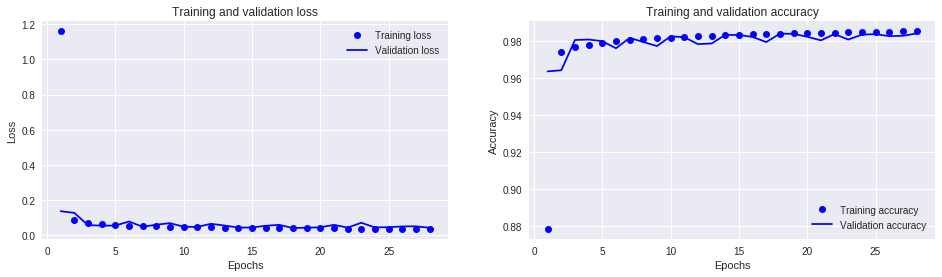

In [15]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 56s 2ms/step
([0.040908910424572426, 0.9841088172860155], 0.989301002095492)
